In [1]:
import tensorflow as tf
import torch
import torchvision
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config BackendInline.figure_format = 'retina'

In [2]:
## Loading the dataset
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.mnist.load_data()
print("X_train shape", X_train.shape, "\ny_train shape", y_train.shape, "\nX_test shape", X_test.shape, "\ny_test shape", y_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape (60000, 28, 28) 
y_train shape (60000,) 
X_test shape (10000, 28, 28) 
y_test shape (10000,)


In [3]:
X = torch.tensor(X_train, dtype=torch.float32).flatten(1)/255
Y = torch.tensor(y_train, dtype=torch.int64)
X_test_data = torch.tensor(X_test, dtype=torch.float32).flatten(1)/255
Y_test_data = torch.tensor(y_test, dtype=torch.int64)

permuts = torch.randperm(X.size(0))
X_train = X[permuts]
y_train = Y[permuts]

permuts_test = torch.randperm(X_test_data.size(0))
X_test = X_test_data[permuts_test]
y_test = Y_test_data[permuts_test]

X_train.size(), y_train.size()

(torch.Size([60000, 784]), torch.Size([60000]))

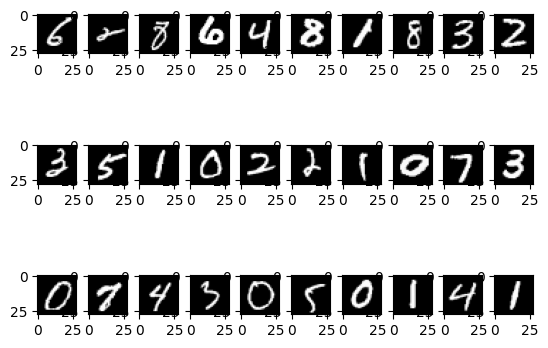

In [4]:
for i in range(1, 31):
    plt.subplot(3, 10, i)
    plt.subplots_adjust(wspace=0.3)
    plt.imshow(X_train[i].numpy().reshape(28, 28), cmap='gray')


In [20]:
## making the model neural net
input_layer = 784
hidden_layer1 = 64
hidden_layer2 = 32
output_layer = 10

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_layer, hidden_layer1)
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.fc3 = nn.Linear(hidden_layer2, output_layer)
    def forward(self, x):
        fc1 = torch.relu(self.fc1(x))
        fc2 = torch.relu(self.fc2(fc1))
        fc3 = self.fc3(fc2)  
        return  fc2, fc3 


#training the model
def train(model,train_data,train_labels,epochs,lr = 0.01,verbose = True):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        fc2_output, final_output = model(train_data)

        
        loss = criterion(final_output, train_labels)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss {loss.item()}')

    return loss.item(), fc2_output, final_output

In [21]:
modelNN = Model()
loss,hidden_layer2, final_output = train(modelNN,X_train,y_train,1000)

Epoch 0, Loss 2.310685634613037
Epoch 10, Loss 0.522423505783081
Epoch 20, Loss 0.3767417371273041
Epoch 30, Loss 0.2819384038448334
Epoch 40, Loss 0.22366593778133392
Epoch 50, Loss 0.1828359067440033
Epoch 60, Loss 0.15249145030975342
Epoch 70, Loss 0.12872594594955444
Epoch 80, Loss 0.11044800281524658
Epoch 90, Loss 0.09536556899547577
Epoch 100, Loss 0.08418399095535278
Epoch 110, Loss 0.07329706102609634
Epoch 120, Loss 0.06468576192855835
Epoch 130, Loss 0.05727217718958855
Epoch 140, Loss 0.05094674974679947
Epoch 150, Loss 0.04512009769678116
Epoch 160, Loss 0.041272927075624466
Epoch 170, Loss 0.036116309463977814
Epoch 180, Loss 0.03159160166978836
Epoch 190, Loss 0.027748268097639084
Epoch 200, Loss 0.02440200187265873
Epoch 210, Loss 0.021478431299328804
Epoch 220, Loss 0.018818795680999756
Epoch 230, Loss 0.016474967822432518
Epoch 240, Loss 0.014416331425309181
Epoch 250, Loss 0.012520378455519676
Epoch 260, Loss 0.010995743796229362
Epoch 270, Loss 0.009668555110692978


In [22]:
print(hidden_layer2.size(), final_output.size())

torch.Size([60000, 32]) torch.Size([60000, 10])


In [24]:
#testing the model using neural networks

def test(model, test_data, test_labels):
    correct = 0
    total = 0
    with torch.no_grad():
        _, outputs = model(test_data) 
        _, predicted = torch.max(outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
        print(f'total: {total}')
        print(f'correct: {correct}')
    return correct / total, predicted

Accuracy , predicted = test(modelNN, X_test, y_test)
print(Accuracy*100)

total: 10000
correct: 9657
96.57


In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def confusion_mat(y_test, predicted_label,label):
    conf_matrix = confusion_matrix(y_test, predicted_label)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, 
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(label)
    plt.show()
    # highly confused classes pairs
    confused_pairs = {}
    for i in range(10):
        for j in range(10):
            if i != j and conf_matrix[i, j] > 0:
                pair = tuple(sorted((i, j)))
                if pair not in confused_pairs:
                    confused_pairs[pair] = 0
                confused_pairs[pair] += conf_matrix[i, j]
    
    sorted_confused_pairs = sorted(confused_pairs.items(), key=lambda x: x[1], reverse=True)
    
    print(sorted_confused_pairs[:4])
    

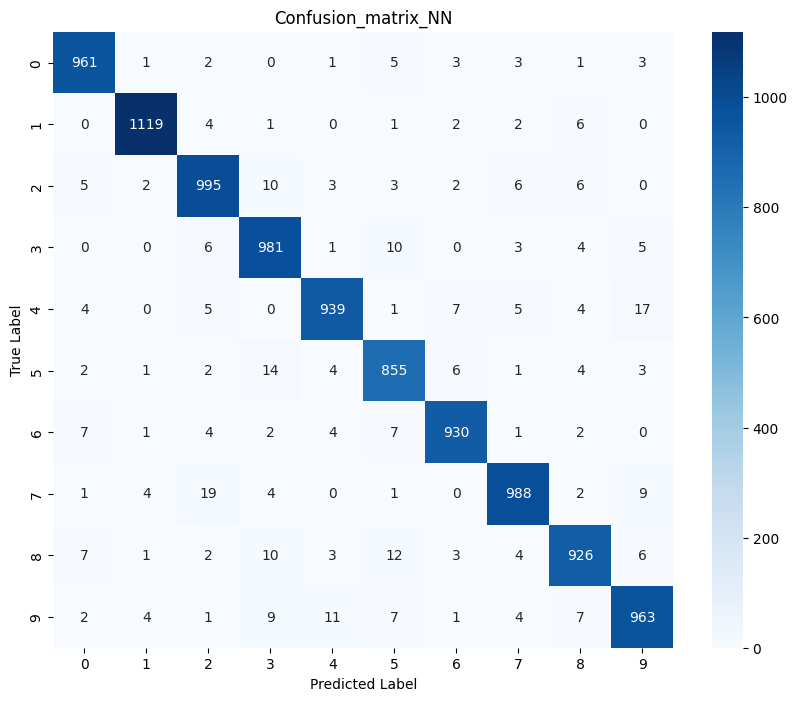

[((4, 9), 28), ((2, 7), 25), ((3, 5), 24), ((2, 3), 16)]


In [25]:
#nn confusion mat
confusion_mat(y_test,predicted,label = "Confusion_matrix_NN")

In [11]:
##multiclass logistic regression
import torch.nn.functional as F

class MultiClassLogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiClassLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        logits = self.linear(x)
        return logits
    

mlr_efficient = MultiClassLogisticRegression(784, 10)    

opt = torch.optim.Adam(mlr_efficient.parameters(), lr=0.01)

converged = False
prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = mlr_efficient(X_train)
    loss = F.cross_entropy(logits, y_train)
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1
    

0 2.2941882610321045
10 0.5807223320007324
20 0.4229988157749176
30 0.36932364106178284
40 0.3410576581954956
50 0.3233848512172699
60 0.310881644487381
70 0.30156761407852173
80 0.2942793369293213
90 0.28828489780426025
100 0.283191978931427
110 0.27878013253211975
120 0.27490511536598206
130 0.27146580815315247
140 0.2683873176574707
150 0.26561203598976135
160 0.2630941867828369
170 0.26079705357551575
180 0.25869083404541016
190 0.25675085186958313
200 0.25495675206184387
210 0.2532912790775299
220 0.25174006819725037
230 0.2502906918525696
240 0.2489326000213623
250 0.24765677750110626
260 0.24645517766475677
270 0.24532106518745422
280 0.24424834549427032
290 0.24323169887065887
300 0.24226650595664978
310 0.2413485199213028
320 0.24047410488128662
330 0.23963989317417145
340 0.23884296417236328
350 0.23808054625988007
360 0.23735029995441437
370 0.2366500347852707
380 0.23597776889801025
390 0.23533160984516144
400 0.2347099632024765
410 0.23411130905151367
420 0.233534306287765

In [12]:
#testing the Logistic regression

pred = F.softmax(mlr_efficient(X_test), dim=-1).detach().numpy()
y_pred = np.argmax(pred, axis=1)

count = 0
for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
        count += 1
print(count/len(y_test)*100)

92.65


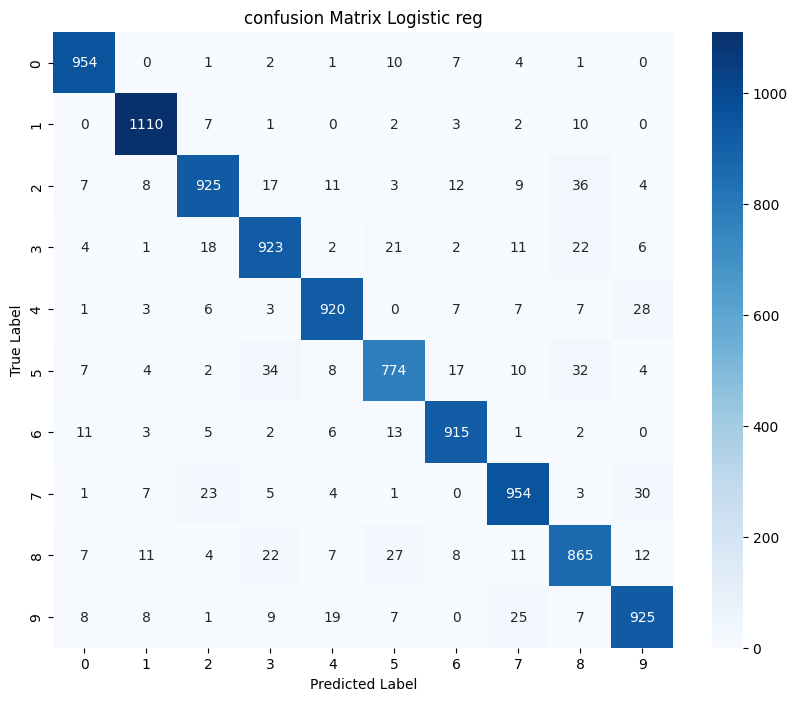

[((5, 8), 59), ((3, 5), 55), ((7, 9), 55), ((4, 9), 47)]


In [13]:
## confusin matrix logistc regression
confusion_mat(y_test,y_pred,label = "confusion Matrix Logistic reg")

In [14]:
#random Forest CLassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Classifier = RandomForestClassifier(n_estimators=100, random_state=42)
Classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
prediction_y = Classifier.predict(X_test)
accuracy = accuracy_score(y_test, prediction_y)
print(accuracy*100)

96.96000000000001


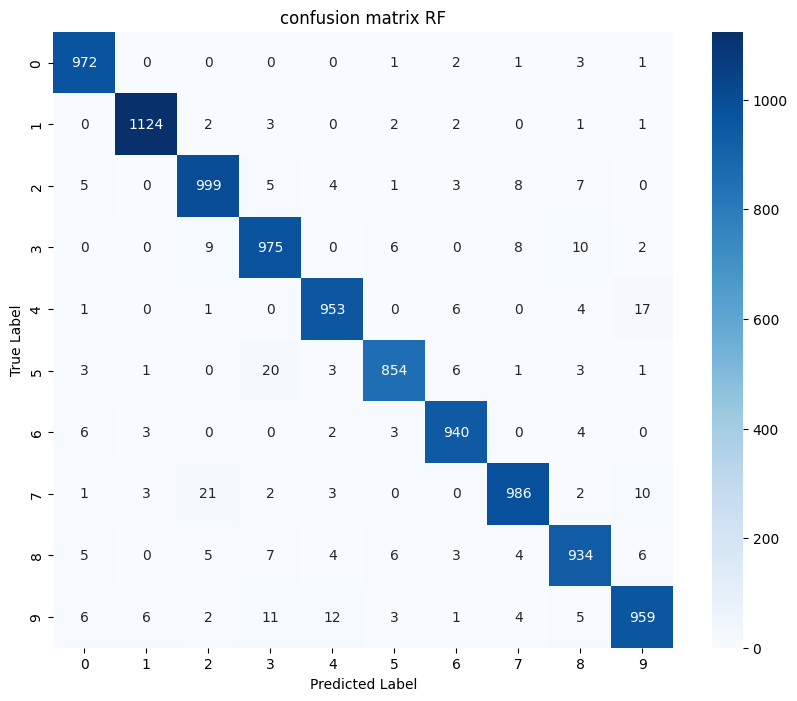

[((2, 7), 29), ((4, 9), 29), ((3, 5), 26), ((3, 8), 17)]


In [16]:
##confusion matrix random forest
confusion_mat(y_test,prediction_y, label = "confusion matrix RF")

**Comparing the 3 models
The accuracy of MLP and RF are almost similar and very high which means they are very well abled to learn the data. The accuracy of Multiclassclassification_logistic regression is around 92% which is also good but less compared to the MLP and RF. This could be due to the large number of neurons in NN which help learning the structures of digits better and similarly large number of trees in RF.**
There are some classes which are often confusing which are printed below the confusion matrix. From the confusion matrix we can see that the 3 models are able to classify the classes very well, the diagonal of the matrix shows this.

In [17]:
#f1-score
from sklearn.metrics import f1_score
print("f1_NN:",f1_score(y_test,predicted, average = None))
print("f1_log:", f1_score(y_test,y_pred,average = None))
print("f1_RF:",f1_score(y_test, prediction_y,average = None))


f1_NN: [0.9857868  0.98720776 0.96407767 0.95481336 0.968107   0.96287964
 0.97325642 0.96357455 0.95812053 0.95794161]
f1_log: [0.96363636 0.96943231 0.91403162 0.91025641 0.93877551 0.88457143
 0.94867807 0.92531523 0.88310362 0.91674926]
f1_RF: [0.9823143  0.98943662 0.96475133 0.95917364 0.97096281 0.96606335
 0.97865695 0.96666667 0.95942476 0.95613161]


The f1-score = 2*TP/(2*TP + FP + FN)
this tells how well a class is being identified , in all three models the f1-score of all classes are mostly more than 0.90 ( f1 for multiclassclassification_logistic gives some some class values less than 0.90 but they are not much less. - those classes might have been misclassified more)